<a href="https://colab.research.google.com/github/andidprastyo/ML-2023/blob/main/13%20-%20OCR%20Manual/OCR_Char_Recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import numpy as np
import imutils
import cv2
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
from google.colab.patches import cv2_imshow

# Load Model

In [2]:
network = load_model('network')
# check summary
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

# Load Image

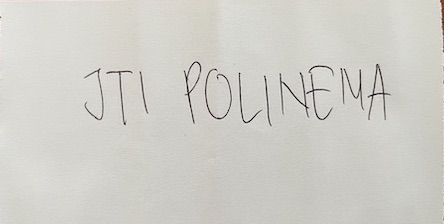

In [3]:
img = cv2.imread('test_image_cropped.jpg')
# show image
cv2_imshow(img)

## Convert to Gray

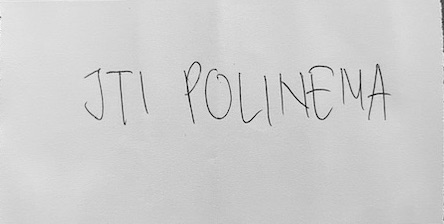

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# show
cv2_imshow(gray)

## Pre-processing

### Remove Noise -> Gaussian Blur

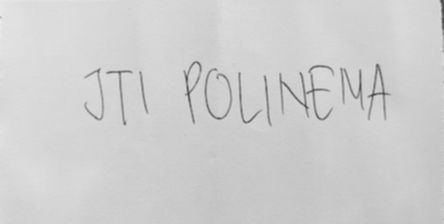

In [5]:
blur = cv2.GaussianBlur(gray, (3,3), 0)
# check
cv2_imshow(blur)

### Adaptive Thresholding

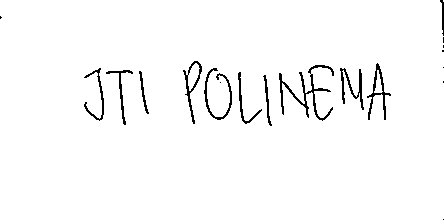

In [6]:
adaptive = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
# check
cv2_imshow(adaptive)

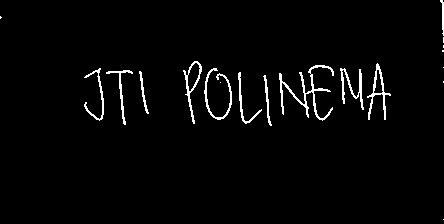

In [7]:
# inverse image since we trained out model
# with black background
invertion = 255 - adaptive
# check
cv2_imshow(invertion)

### Dilation

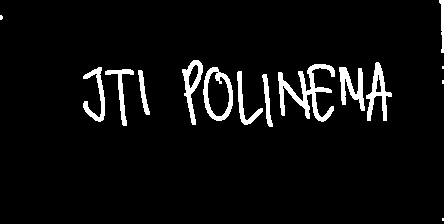

In [8]:
dilation = cv2.dilate(invertion, np.ones((3,3)))
# check
cv2_imshow(dilation)

### Edge Detecton - Canny

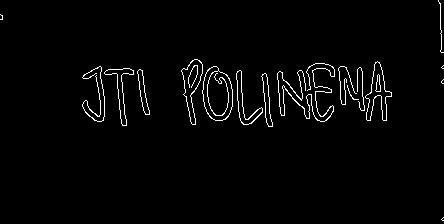

In [9]:
edges = cv2.Canny(dilation, 40, 150)
cv2_imshow(edges)

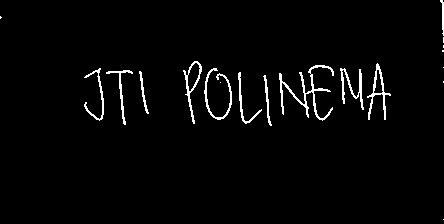

In [10]:
# Test erode
erode = cv2.erode(invertion, np.ones((1,1)))
cv2_imshow(erode)

## Contour Detection

In [11]:
# Define function for contour detection
def find_contours(img):
  conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sort_contours(conts, method='left-to-right')[0]

  return conts

In [12]:
conts = find_contours(dilation.copy())

In [13]:
# Check contour value
conts

(array([[[ 0, 15]],
 
        [[ 0, 19]],
 
        [[ 1, 19]],
 
        [[ 2, 18]],
 
        [[ 2, 16]],
 
        [[ 1, 15]]], dtype=int32),
 array([[[ 98,  67]],
 
        [[ 96,  69]],
 
        [[ 94,  69]],
 
        [[ 93,  70]],
 
        [[ 92,  70]],
 
        [[ 90,  72]],
 
        [[ 89,  72]],
 
        [[ 88,  73]],
 
        [[ 87,  73]],
 
        [[ 86,  74]],
 
        [[ 85,  74]],
 
        [[ 83,  76]],
 
        [[ 83,  78]],
 
        [[ 87,  78]],
 
        [[ 88,  77]],
 
        [[ 89,  77]],
 
        [[ 91,  75]],
 
        [[ 92,  75]],
 
        [[ 93,  74]],
 
        [[ 94,  74]],
 
        [[ 95,  73]],
 
        [[ 96,  73]],
 
        [[ 97,  74]],
 
        [[ 96,  75]],
 
        [[ 96,  77]],
 
        [[ 97,  78]],
 
        [[ 97,  82]],
 
        [[ 98,  83]],
 
        [[ 98,  87]],
 
        [[ 99,  88]],
 
        [[ 99,  93]],
 
        [[100,  94]],
 
        [[100, 100]],
 
        [[101, 101]],
 
        [[101, 113]],
 
        [[100, 

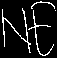

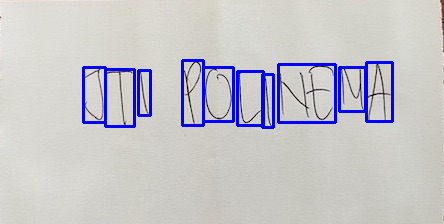

In [14]:
# Get the char based on contour

# Setup min/max width/hight for char
min_w, max_w = 10, 160
min_h, max_h = 14, 140
img_copy = img.copy()

for c in conts:
  (x, y, w, h) = cv2.boundingRect(c) # find bounding box based on contour
  if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h): # if pixel follow this rule, it consider as char
    roi = gray[y:y+h, x:x+w] # get region of interest for char
    thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    cv2_imshow(thresh) # check

    # Build bounding box on original image
    cv2.rectangle(img_copy, (x,y), (x+w, y+h), (255,0,0), 2)

# Show bounding box on original image
cv2_imshow(img_copy)

# Detect Char

## ROI extraction

In [15]:
def extract_roi(img):
  roi = img[y:y+h, x:x+w]

  return roi

## Thresholding

In [16]:
def thresholding(img):
  thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  return thresh

## Resizing

- Inorder to make our char detection size match with input model
- Strategies:
   - Rather shrinking or enlarge the image, we try to fill the image with black pixel, and make our char stay in ration
   - We also makes our extracted char stay at the center of image

In [17]:
def resize_img(img, w, h):
  if w > h:
    resized = imutils.resize(img, width=28)
  else:
    resized = imutils.resize(img, height=28)

  # (w, h) = resized.shape
  (h, w) = resized.shape

  # Calculate how many pixels need to fill char image
  dX = int(max(0, 28 - w) / 2.0)
  dY = int(max(0, 28 - h) / 2.0)

  filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
  filled = cv2.resize(filled, (28,28))

  return filled

In [18]:
# Demo for enlarge
(x, y, w, h) = cv2.boundingRect(conts[1])
test_image = thresholding(gray[y:y+h, x:x+w])

# show original test image
cv2_imshow(test_image)

# Show enlarge test image
cv2_imshow(cv2.resize(test_image, (28,28)))

In [19]:
# Demo by filled strategy
# (w, h) = test_image.shape
(h, w) = test_image.shape

test_image2 = resize_img(test_image, w, h)

cv2_imshow(test_image)
cv2_imshow(test_image2)

## Normalization

In [20]:
def normalization(img):
  img = img.astype('float32') / 255.0 # convert to floating point
  img = np.expand_dims(img, axis=-1) # add depth
  return img

In [21]:
# Check
test_image2.shape, normalization(test_image2).shape

((28, 28), (28, 28, 1))

# Detection

In [22]:
def process_box(gray, x, y, w, h):

  roi = extract_roi(gray)
  thresh = thresholding(roi)
  (h, w) = thresh.shape
  resized = resize_img(thresh, w, h)

  # show result
  cv2_imshow(resized)

  normalized = normalization(resized)

  return (normalized, (x, y, w, h))

In [23]:
# Detect every single char from contour
detected_char = []

for c in conts:
  (x, y, w, h ) = cv2.boundingRect(c)

  min_w, max_w = 10, 160
  min_h, max_h = 14, 140

  if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    detected_char.append(process_box(gray, x, y, w, h))

In [24]:
# check pixel for detected char sample
detected_char[0][0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.2       ],
        [0.30588236],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.11372549],
        [0.45490196],
        [0.7411765 ],
        

In [25]:
# check bounding box for detected char sample
detected_char[0][1]

(83, 67, 22, 55)

In [26]:
# Get all char pixel
pixels = np.array([px[0] for px in detected_char], dtype='float32')

# Get all box for detected char
boxes = [box[1] for box in detected_char]

# Recognize Char

In [27]:
digits = '0123456789'
letters = 'ABCDEFGHIJKLMNOPQRSTUVWZYZ'
char_list = digits + letters
char_list = [ch for ch in char_list]

print(char_list)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', 'Y', 'Z']


In [28]:
# Predict
preds = network.predict(pixels)

# check shape -> JTI POLINEMA --> shoud be 11 (from 0 to 10)
preds.shape

1/1 [==============================] - 7s 7s/step


(10, 36)

In [29]:
# Char Prediction
for p in preds:
  char_idx = np.argmax(p)
  print(char_list[char_idx], end = " ")

J T 1 P O L Y H N A 

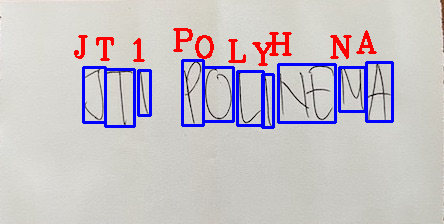

In [30]:
# Show char with actual image
img_copy2 = img.copy()

for(pred, (x, y, w, h)) in zip(preds, boxes):
  i = np.argmax(pred)
  char_detected = char_list[i]

  cv2.rectangle(img_copy2, (x, y), (x+w, y+h), (255,0,0), 2)
  cv2.putText(img_copy2, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)

cv2_imshow(img_copy2)

## Put Margin On Bounding Box

Due to our bounding box very very close to the char, lets extend the roi margin

In [31]:
# Redefine roi --> include margin
def extract_roi(img, margin=2):
  roi = img[y - margin:y+h, x - margin:x + w + margin]
  return roi

In [32]:
# Perform detection agian
conts2 = find_contours(dilation.copy())

# Detect every single char from contour
detected_char = []

for c in conts2:
  (x, y, w, h ) = cv2.boundingRect(c)

  min_w, max_w = 10, 160
  min_h, max_h = 14, 140

  if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    detected_char.append(process_box(gray, x, y, w, h))

In [33]:
# Get all char pixel
pixels = np.array([px[0] for px in detected_char], dtype='float32')

# Get all box for detected char
boxes = [box[1] for box in detected_char]

In [34]:
# Predict
preds = network.predict(pixels)

# check shape -> JTI POLINEMA --> shoud be 11 (from 0 to 10)
preds.shape

1/1 [==============================] - 0s 25ms/step


(10, 36)

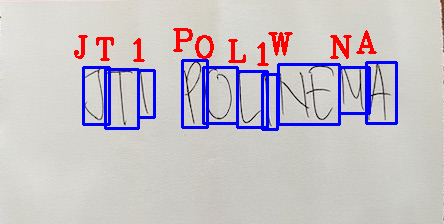

In [35]:
# Show char with actual image
img_copy3 = img.copy()

for(pred, (x, y, w, h)) in zip(preds, boxes):
  i = np.argmax(pred)
  char_detected = char_list[i]

  cv2.rectangle(img_copy3, (x, y), (x+w, y+h), (255,0,0), 2)
  cv2.putText(img_copy3, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)

cv2_imshow(img_copy3)

# Problem with 0, O, 1, I, 5, and S

In [36]:
# dumb solution :))
digits = '0I23456789'
letters = 'ABCDEFGHIJKLMNOPQRSTUVWZYZ'
char_list = digits + letters
char_list = [ch for ch in char_list]

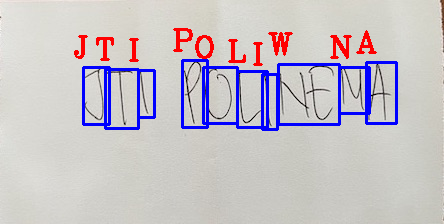

In [37]:
img_copy4 = img.copy()

for(pred, (x, y, w, h)) in zip(preds, boxes):
  i = np.argmax(pred)
  char_detected = char_list[i]

  cv2.rectangle(img_copy4, (x, y), (x+w, y+h), (255,0,0), 2)
  cv2.putText(img_copy4, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)

cv2_imshow(img_copy4)

# Problem With Undetected Text

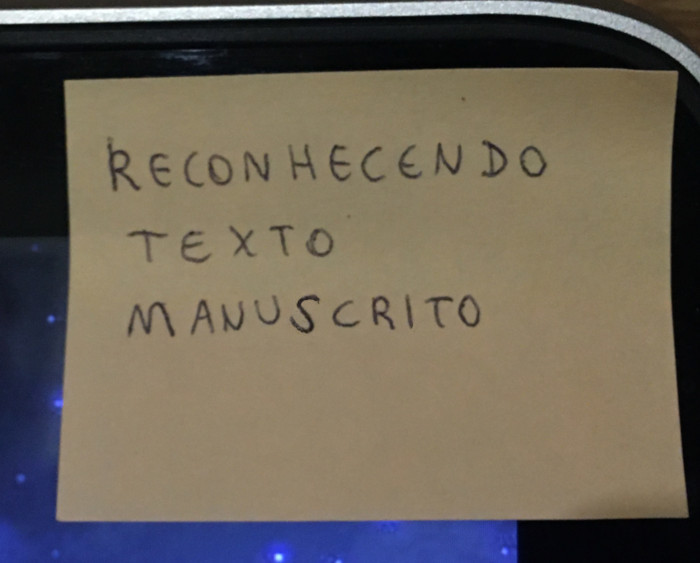

In [38]:
img_border = cv2.imread('test_undetected.png')
cv2_imshow(img_border)

In [39]:
# Create simple pre-processing method
def preprocess_img(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, (3,3), 7)
  edges = cv2.Canny(blur, 40, 150)
  dilation = cv2.dilate(edges, np.ones((3,3)))

  return gray, dilation


# Prediction
def prediction(preds, char_list):
  i = np.argmax(preds)
  prop = preds[i]
  char_detect = char_list[i]

  return i, prop, char_detect

# Draw char on image
def draw_img(img_cp, char):
  cv2.rectangle(img_cp, (x, y), (x + w, y + h), (255, 0, 0), 2)
  cv2.putText(img_cp, char, (x - 10, y - 10), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255),2)

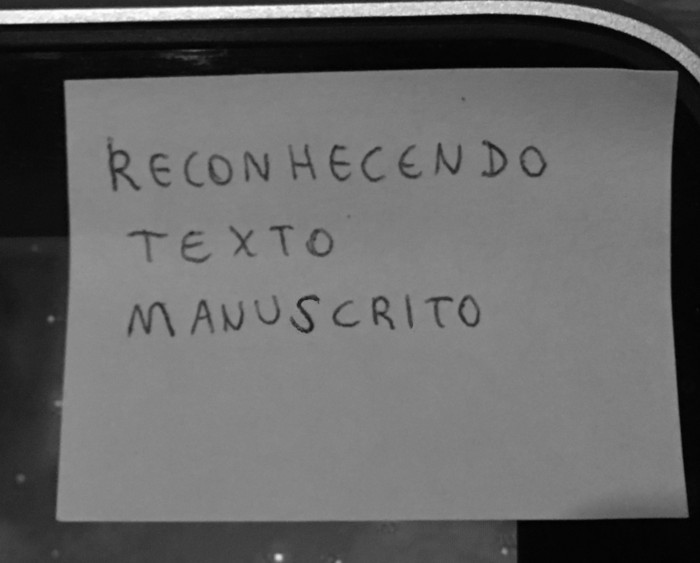

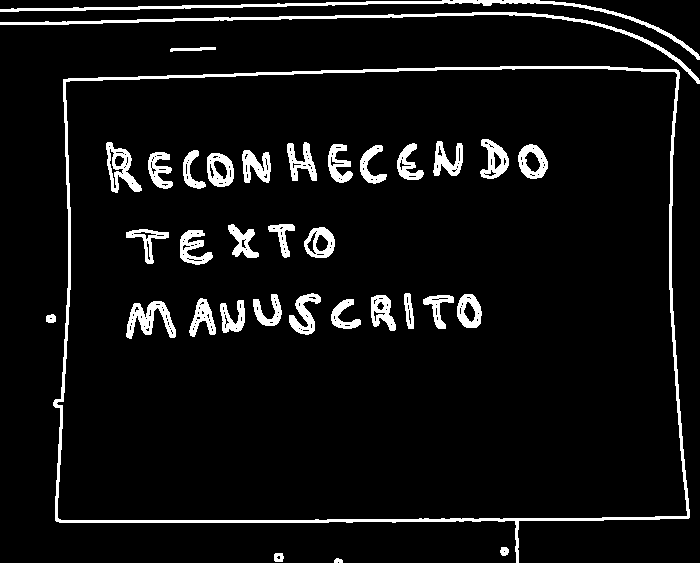

In [40]:
gray, prep_img = preprocess_img(img_border)
cv2_imshow(gray) # show gray
cv2_imshow(prep_img) # show img after several preprocessing

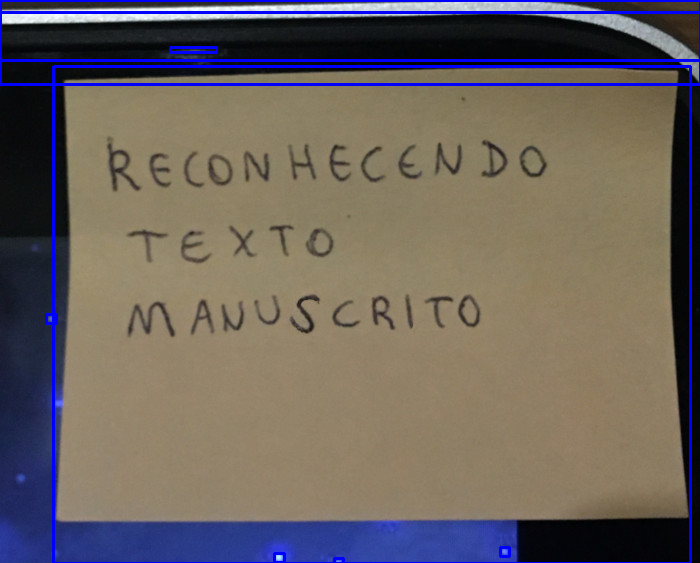

In [41]:
# Check contour
conts_border = find_contours(prep_img.copy())

img_cp = img_border.copy()
for c in conts_border:
  (x, y, w, h) = cv2.boundingRect(c)
  roi = gray[y:y+h, x:x+w]
  thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  # draw detected contour
  cv2.rectangle(img_cp, (x, y), (x + w, y + h), (255,0,0), 2)
cv2_imshow(img_cp)

In [42]:
# Check detected contour

height, width = img_border.shape[:2]
print(height, width)

# Sort contours from the largest one
contours_size = sorted(conts_border, key=cv2.contourArea, reverse=True)
contours_size

563 700


[array([[[500,  66]],
 
        [[499,  67]],
 
        [[435,  67]],
 
        [[434,  68]],
 
        [[397,  68]],
 
        [[396,  69]],
 
        [[363,  69]],
 
        [[362,  70]],
 
        [[321,  70]],
 
        [[320,  71]],
 
        [[292,  71]],
 
        [[291,  72]],
 
        [[256,  72]],
 
        [[255,  73]],
 
        [[234,  73]],
 
        [[233,  74]],
 
        [[203,  74]],
 
        [[202,  75]],
 
        [[167,  75]],
 
        [[166,  76]],
 
        [[138,  76]],
 
        [[137,  77]],
 
        [[ 98,  77]],
 
        [[ 97,  78]],
 
        [[ 68,  78]],
 
        [[ 67,  79]],
 
        [[ 63,  79]],
 
        [[ 63, 101]],
 
        [[ 64, 102]],
 
        [[ 64, 122]],
 
        [[ 65, 123]],
 
        [[ 65, 156]],
 
        [[ 66, 157]],
 
        [[ 66, 184]],
 
        [[ 67, 185]],
 
        [[ 67, 208]],
 
        [[ 68, 209]],
 
        [[ 68, 287]],
 
        [[ 67, 288]],
 
        [[ 67, 304]],
 
        [[ 66, 305]],
 
        [[ 66, 3

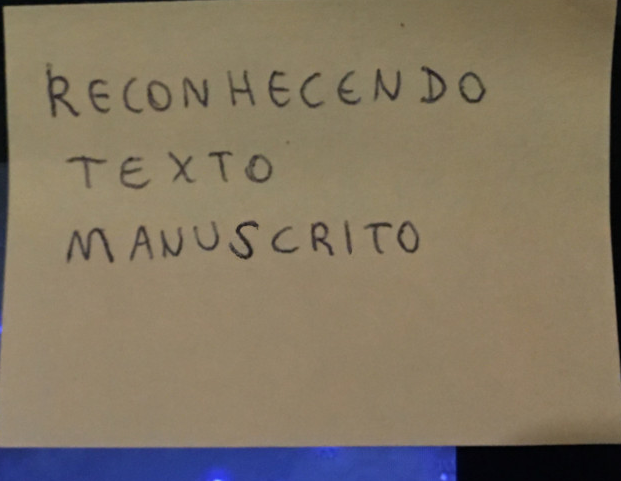

In [43]:
# Since we know our text placed in piece of paper
# just extract that area by crop it

for c in contours_size:
  (x, y, w, h) = cv2.boundingRect(c)

  if(w >= (width / 2)) and (h >= height / 2):
    cut_off = 8 # you can adjust it based on your images
    cut_img = img_border[y+cut_off:y + h - cut_off, x + cut_off: x + w - cut_off]
    cv2_imshow(cut_img)

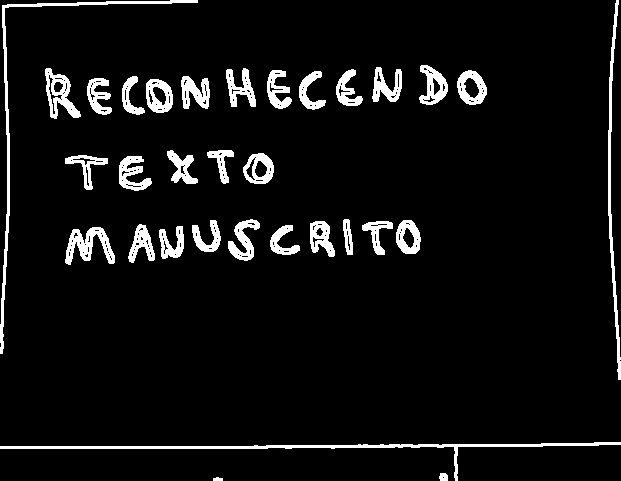

In [44]:
# do it again for cropped image

gray, prep_img = preprocess_img(cut_img)
cv2_imshow(prep_img)

1/1 [==============================] - 0s 95ms/step


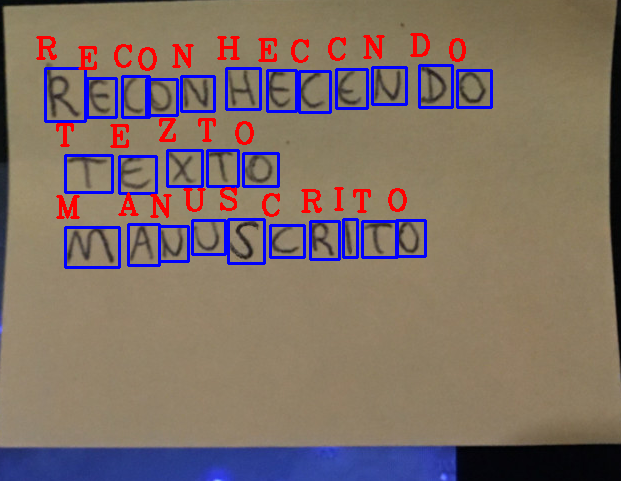

In [45]:
conts_cut = find_contours(prep_img.copy())
chars = []

for c in conts_cut:
  (x, y, w, h) = cv2.boundingRect(c)

  if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
    chars.append(process_box(gray, x, y, w, h))

boxes = [b[1] for b in chars]
pixels = np.array([p[0] for p in chars], dtype='float32')

preds = network.predict(pixels)

img_cp = cut_img.copy()
for (pred, (x, y, w, h)) in zip (preds, boxes):
  i, prop, ch = prediction(pred, char_list)
  draw_img(img_cp, ch)
cv2_imshow(img_cp)